In [ ]:
!pip install torch==2.2.0 transformers==4.42.4 sentence-transformers==2.7.0 pandas scikit-learn


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
# from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
!pip install datasets

In [ ]:
# prompt: pip install flash_attn

!pip install flash_attn


In [ ]:
import torch
from sentence_transformers import SentenceTransformer


# Load the Stella model
model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()

# Set the model sequence length
model.max_seq_length = 512  # Maximum sequence length supported by the model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(





KeyboardInterrupt: 

In [ ]:
# Load your dataset
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/llm_outputs_ollama_with_time.csv")

# Add EOS token to each input and output
def add_eos(text_list):
    # print(model.tokenizer.eos_token)
    # print(text_list)
    return [str(text) + model.tokenizer.eos_token for text in text_list]

df['xi_eos'] = add_eos(df['Input Prompt'].tolist())
df['xj_eos'] = add_eos(df['LLM Output'].tolist())

# Convert LLM labels into numerical codes
df['label_encoded'] = pd.Categorical(df['Used LLM']).codes
df

In [ ]:
# Function to generate embeddings
def generate_embeddings(texts, model, batch_size=64):
    return model.encode(texts, batch_size=batch_size, normalize_embeddings=True)

# Generate embeddings for input and output texts
xi_embeddings = generate_embeddings(df['xi_eos'].tolist(), model)
xj_embeddings = generate_embeddings(df['xj_eos'].tolist(), model)

# Combine embeddings of xi and xj for each input-output pair
combined_embeddings = [torch.cat((torch.tensor(xi), torch.tensor(xj))) for xi, xj in zip(xi_embeddings, xj_embeddings)]


In [ ]:
# import pickle

# # Save the combined embeddings to a file
# with open('/content/drive/MyDrive/combined_embeddings.pkl', 'wb') as f:
#     pickle.dump(combined_embeddings, f)

# print("Combined embeddings saved successfully.")


In [3]:
# # Load your dataset
# import pandas as pd
# df = pd.read_csv("/content/drive/MyDrive/llm_outputs_ollama_with_time.csv")
# df['label_encoded'] = pd.Categorical(df['Used LLM']).codes


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import pickle

# # Load the combined embeddings from the file
# with open('/content/drive/MyDrive/combined_embeddings.pkl', 'rb') as f:
#     combined_embeddings = pickle.load(f)

In [8]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[1]  # CLS token's output
        out = self.fc(cls_output)
        return out


In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a dataset class
class LLMClassifierDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Define the neural network model
class LLMClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LLMClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Prepare data
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, df['label_encoded'].tolist(), test_size=0.2, random_state=42)

# Create dataset and dataloader
train_dataset = LLMClassifierDataset(X_train, y_train)
test_dataset = LLMClassifierDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
from transformers import BertTokenizer, BertModel, AdamW

# Initialize the model, loss function, and optimizer
# model_classifier = BERTClassifier(num_classes=len(df['label_encoded'].unique()))

model_classifier = LLMClassifier(input_size=2048, num_classes=len(df['label_encoded'].unique()))  # Input size = 2048 (two 1024-dimensional embeddings concatenated)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_classifier.parameters(), lr=1e-4)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_classifier.to(device)


LLMClassifier(
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [10]:
# Training function
def train(model, train_loader, optimizer, loss_fn, epochs=5+5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Train the model
train(model_classifier, train_loader, optimizer, loss_fn)


<ipython-input-9-52699972c462>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Epoch 1, Loss: 0.965177235548695
Epoch 2, Loss: 0.5925307305107514
Epoch 3, Loss: 0.5066007704784473
Epoch 4, Loss: 0.4629412461668253
Epoch 5, Loss: 0.43606955774873496
Epoch 6, Loss: 0.41653616448119285
Epoch 7, Loss: 0.401500541780144
Epoch 8, Loss: 0.389742914211005
Epoch 9, Loss: 0.37983110349749527
Epoch 10, Loss: 0.3707531965685387


In [14]:
# prompt: change this evaluate to return true_labels, pred_labels = evaluate(model, test_loader)

def evaluate(model, test_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy().tolist())
            pred_labels.extend(predicted.cpu().numpy().tolist())

    return true_labels, pred_labels

# Evaluate the model
true_labels, pred_labels = evaluate(model_classifier, test_loader)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")


<ipython-input-9-52699972c462>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Accuracy: 0.8469166666666667


In [15]:
print(true_labels)  # Print true labels
print(pred_labels)  # Print predicted labels

[5, 4, 0, 2, 2, 1, 3, 0, 1, 5, 4, 3, 5, 5, 3, 4, 3, 5, 0, 3, 1, 0, 5, 4, 1, 0, 1, 2, 3, 4, 0, 4, 0, 1, 3, 5, 2, 2, 1, 2, 2, 0, 4, 5, 5, 2, 0, 4, 4, 1, 1, 3, 3, 2, 2, 1, 1, 2, 0, 0, 1, 0, 0, 3, 5, 0, 1, 3, 4, 1, 3, 1, 0, 2, 5, 1, 5, 0, 3, 2, 1, 4, 5, 3, 3, 1, 2, 4, 2, 4, 5, 3, 4, 5, 1, 3, 1, 0, 5, 5, 3, 0, 1, 3, 5, 4, 3, 1, 3, 5, 4, 5, 5, 0, 4, 5, 4, 0, 2, 5, 0, 5, 2, 5, 0, 0, 2, 1, 3, 4, 0, 0, 4, 4, 2, 3, 2, 1, 2, 3, 3, 3, 5, 3, 4, 1, 3, 3, 3, 5, 4, 2, 4, 4, 0, 1, 5, 1, 0, 3, 1, 1, 1, 1, 4, 2, 1, 4, 1, 0, 2, 4, 0, 4, 5, 1, 0, 0, 5, 5, 1, 5, 0, 3, 4, 2, 4, 5, 4, 4, 1, 4, 3, 2, 3, 1, 4, 5, 1, 5, 3, 5, 2, 0, 1, 0, 1, 1, 2, 1, 4, 4, 3, 3, 4, 5, 0, 1, 0, 1, 3, 0, 5, 3, 2, 2, 0, 2, 4, 4, 4, 5, 1, 2, 3, 1, 5, 4, 2, 3, 1, 4, 2, 1, 5, 5, 3, 2, 0, 5, 1, 0, 4, 4, 5, 1, 2, 0, 4, 0, 5, 0, 5, 2, 2, 0, 4, 4, 4, 0, 3, 0, 1, 5, 1, 3, 0, 0, 5, 2, 0, 3, 0, 4, 5, 5, 5, 1, 1, 0, 0, 1, 1, 2, 5, 5, 1, 1, 2, 1, 1, 2, 3, 4, 3, 1, 0, 0, 1, 3, 5, 2, 5, 3, 0, 0, 3, 0, 4, 1, 4, 5, 0, 1, 2, 1, 5, 2, 1, 1, 5, 2, 2, 

In [11]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Evaluate the model
evaluate(model_classifier, test_loader)


<ipython-input-9-52699972c462>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Test Accuracy: 84.69%


<ipython-input-9-52699972c462>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1936
           1       0.85      0.76      0.80      2014
           2       0.97      0.98      0.97      2036
           3       0.80      0.81      0.81      2051
           4       0.84      0.76      0.80      2000
           5       0.71      0.82      0.76      1963

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



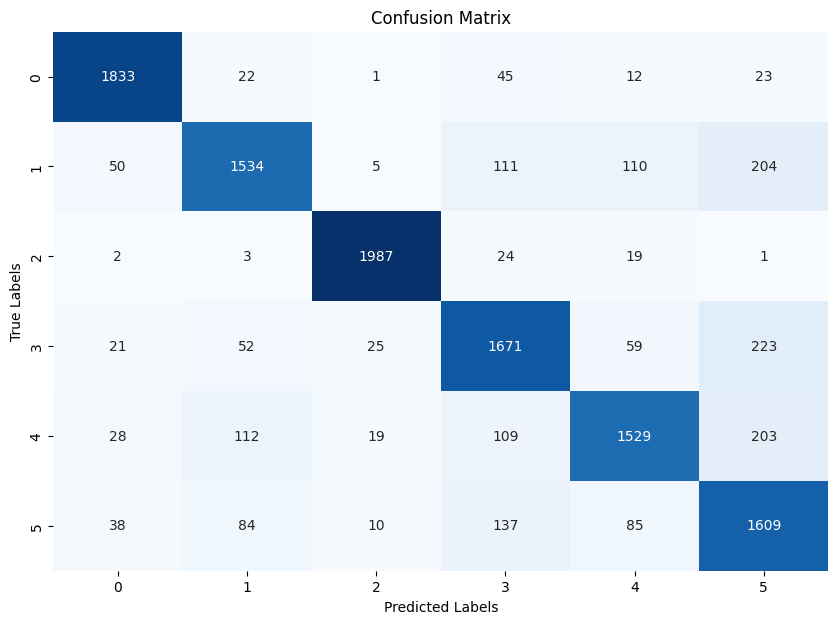

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # Assuming true_labels and pred_labels are available
# true_labels = [...]  # Replace with your actual true labels
# pred_labels = [...]  # Replace with your actual predicted labels
true_labels, pred_labels = evaluate(model_classifier, test_loader)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=1)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

# Generate a classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, zero_division=1))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# # prompt: download the above csv

# from google.colab import files

# files.download('/content/drive/MyDrive/test_loader_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model_classifier, 'stella_classifier_model.pth')
from google.colab import files

# Download the saved model file
files.download('/content/stella_classifier_model.pth')  # or 'bert_classifier_model.pth'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


We are building a model to classify LLM outputs based on the LLM used to generate them.

1. Data Preparation:
   - Load a dataset that contains input prompts, LLM outputs, and the name of the LLM used.
   - Preprocess the data by adding EOS tokens and converting LLM labels to numerical codes.
   - Use a SentenceTransformer (Stella model) to generate embeddings for input prompts and outputs.
   - Combine the input and output embeddings for each pair.

2. Model Building:
   - Define a neural network model (LLMClassifier) that takes the combined embeddings as input and predicts the LLM type (label).

3. Data Splitting and Loading:
   - Split the dataset into training and testing sets.
   - Create datasets and data loaders for training and testing.

4. Training:
   - Initialize the model, loss function, and optimizer.
   - Move the model to the GPU if available.
   - Train the model using the training data loader, optimizing the model's parameters to improve classification accuracy.

5. Evaluation:
   - Evaluate the trained model using the testing data loader.
   - Calculate accuracy, precision, recall, F1-score, and create a classification report and a confusion matrix to assess performance.

6. Saving the Model:
   - Save the trained model for future use or deployment.


Bert classifier from below:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the BERT-based classifier with selective layer fine-tuning
class BERTClassifier(nn.Module):
    def __init__(self, num_classes, fine_tune_layers=4):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, num_classes)  # Multiply by 2 to handle concatenation of two embeddings

        # Freeze all BERT layers first
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last `fine_tune_layers` layers of BERT
        for param in self.bert.encoder.layer[-fine_tune_layers:].parameters():
            param.requires_grad = True

    def forward(self, input_ids_prompt, attention_mask_prompt, input_ids_output, attention_mask_output):
        # Encode the Input Prompt and LLM Output separately
        prompt_output = self.bert(input_ids_prompt, attention_mask=attention_mask_prompt)[1]  # CLS token output
        output_output = self.bert(input_ids_output, attention_mask=attention_mask_output)[1]  # CLS token output

        # Concatenate the embeddings of Input Prompt and LLM Output
        combined_output = torch.cat((prompt_output, output_output), dim=1)

        # Pass through the classifier
        out = self.fc(combined_output)
        return out

# Dataset preparation
class LLMTextDataset(Dataset):
    def __init__(self, prompts, outputs, labels, tokenizer, max_len):
        self.prompts = prompts
        self.outputs = outputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        output = self.outputs[idx]
        label = self.labels[idx]
        # Tokenize both Input Prompt and LLM Output separately, handling potential NaN values
        prompt = str(prompt) if pd.notna(prompt) else "[UNK]"  # Replace NaN with [UNK]
        output = str(output) if pd.notna(output) else "[UNK]"  # Replace NaN with [UNK]

        # Tokenize both Input Prompt and LLM Output separately
        prompt_encoding = self.tokenizer.encode_plus(
            prompt,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        output_encoding = self.tokenizer.encode_plus(
            output,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids_prompt': prompt_encoding['input_ids'].flatten(),
            'attention_mask_prompt': prompt_encoding['attention_mask'].flatten(),
            'input_ids_output': output_encoding['input_ids'].flatten(),
            'attention_mask_output': output_encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/llm_outputs_ollama_with_time.csv")
df['label_encoded'] = pd.Categorical(df['Used LLM']).codes  # Encode the labels
prompts = df['Input Prompt'].tolist()
outputs = df['LLM Output'].tolist()
labels = df['label_encoded'].tolist()

# Split the data
X_train_prompts, X_test_prompts, X_train_outputs, X_test_outputs, y_train, y_test = train_test_split(
    prompts, outputs, labels, test_size=0.2, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_CLASSES = len(df['label_encoded'].unique())
LEARNING_RATE = 2e-5

# Create DataLoader for training and testing
train_dataset = LLMTextDataset(X_train_prompts, X_train_outputs, y_train, tokenizer, MAX_LEN)
test_dataset = LLMTextDataset(X_test_prompts, X_test_outputs, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(num_classes=NUM_CLASSES, fine_tune_layers=4).to(device)  # Fine-tune the last 4 layers
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Training loop with selective layer fine-tuning, with loss and accuracy printing
def train(model, train_loader, optimizer, loss_fn, epochs=EPOCHS):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids_prompt = batch['input_ids_prompt'].to(device)
            attention_mask_prompt = batch['attention_mask_prompt'].to(device)
            input_ids_output = batch['input_ids_output'].to(device)
            attention_mask_output = batch['attention_mask_output'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids_prompt, attention_mask_prompt, input_ids_output, attention_mask_output)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loss.backward()
            optimizer.step()

        # Calculate accuracy
        train_accuracy = correct / total
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {train_accuracy * 100:.2f}%")

# Evaluation loop
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids_prompt = batch['input_ids_prompt'].to(device)
            attention_mask_prompt = batch['attention_mask_prompt'].to(device)
            input_ids_output = batch['input_ids_output'].to(device)
            attention_mask_output = batch['attention_mask_output'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids_prompt, attention_mask_prompt, input_ids_output, attention_mask_output)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return all_labels, all_preds

# Plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Distribution of predictions
def plot_predictions_distribution(pred_labels):
    unique, counts = np.unique(pred_labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Prediction Distribution')
    plt.show()

# Train the model
train(model, train_loader, optimizer, loss_fn, epochs=EPOCHS)




In [ ]:
torch.save(model, 'bert_classifier_model.pth')
from google.colab import files

# Download the saved model file
files.download('/content/bert_classifier_model.pth')  # or 'bert_classifier_model.pth'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = torch.load('bert_classifier_model.pth')


In [ ]:
# Evaluate the model and get predictions
true_labels, pred_labels = evaluate(model, test_loader)

# Plot confusion matrix and distribution of predictions
plot_confusion_matrix(true_labels, pred_labels)
plot_predictions_distribution(pred_labels)